# Mounting to the Drive and loading packages

In [1]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [2]:
import sys, importlib, os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.utils
from typing import Tuple
import yaml
from pathlib import Path
from datetime import datetime

In [3]:
# Importing project packages
cwd = Path(os.getcwd())
root_dir = cwd.parent

utils_dir = root_dir.joinpath('src','utils')
weights_dir = root_dir.joinpath('checkpoints','weights')
model_dir = root_dir.joinpath('src','model')
yaml_file_path = root_dir.joinpath('experiments','base_config.yaml')


# Making packages importable
sys.path.append(str(root_dir))

In [4]:
from src.utils import subVP_SDE, subVP_processes
from src.models import unet_model, components

importlib.reload(subVP_SDE)
importlib.reload(subVP_processes)
importlib.reload(components)
importlib.reload(unet_model)

from src.utils.subVP_SDE import subVP_SDE
from src.utils.subVP_processes import DiffusionProcesses
from src.models.components import SinusoidalPositionEmbeddings # Required by unet_model
from src.models.unet_model import UNet

# Weights to test

In [5]:
weights_name = "LDM_final_T1000_LR00001_E100_SA.pth"

# Defining `ReverseConfig`

In [6]:
import os
import yaml
import torch
from typing import Tuple

def load_cfg_from_yaml_and_args(yaml_file_path):
    """
    Read YAML config (args.config_path) and override with CLI args.
    Returns the `cfg` dict with ForwardConfig, ReverseConfig, LikelihoodConfig.
    """
    # 1) Load YAML (if present)

    with open(yaml_file_path, 'r') as f:
        yaml_config = yaml.safe_load(f) or {}

    # 2) helper: CLI override > YAML > None
    def get_param(key):
        return yaml_config.get(key)

    # 3) Extract commonly-used params (same names as in your original script)
    beta_min   = get_param('beta_min')
    beta_max   = get_param('beta_max')
    N_timesteps = get_param('n_timesteps')
    schedule   = get_param('schedule')
    seed       = get_param('seed')
    t_forward  = get_param('t_forward')
    final      = get_param('final')
    eps        = get_param('eps')
    closed_formula = get_param('closed_formula')

    t_0        = get_param('t_0')
    t_1        = get_param('t_1')
    corrector  = get_param('corrector')
    n_corr     = get_param('n_corr')
    target_snr = get_param('target_snr')
    rev_type   = get_param('rev_type')

    epochs     = get_param('epochs')
    lr         = get_param('learning_rate')
    batch_size = get_param('batch_size')
    model_type = get_param('model')
    use_is     = get_param('use_importance_sampling')
    latent_ch  = get_param('latent_channels')
    image_size = get_param('image_size')
    vae_scale  = get_param('vae_scale_factor')
    vae_factor = get_param('vae_factor')
    val_split  = get_param('validation_split_ratio')
    feats      = get_param('features')
    attn       = get_param('self_attention')
    workers    = get_param('num_workers')
    early_stopping_patience = get_param('early_stopping_patience')

    # Provide sensible defaults if still None
    if latent_ch is None: latent_ch = 4
    if image_size is None: image_size = 128
    if vae_factor is None: vae_factor = 8
    if N_timesteps is None: N_timesteps = 1000
    if beta_min is None: beta_min = 0.1
    if beta_max is None: beta_max = 20.0
    if seed is None: seed = 42
    if lr is None: lr = 1e-4
    if batch_size is None: batch_size = 64
    if workers is None: workers = 0
    if feats is None: feats = [128, 256, 512]
    if early_stopping_patience is None: early_stopping_patience = 10

    # latent spatial dims
    latent_h = image_size // vae_factor
    latent_w = image_size // vae_factor

    # shape for reverse process (batch dimension is left as placeholder)
    current_shape = (batch_size, latent_ch, latent_h, latent_w)

    # Build the cfg dict (same structure you expect downstream)
    cfg = {
        'ForwardConfig': {
            't': t_forward,
            'final': final,
            'eps': eps,
            'closed_formula': closed_formula,
            'seed': seed,
            'beta_min': beta_min,
            'beta_max': beta_max,
            'N': N_timesteps,
            'schedule': schedule,
            'use_importance_sampling': use_is,
            'latent_channels': latent_ch,
            'image_size': image_size,
            'vae_scale_factor': vae_scale,
            'validation_split_ratio': val_split,
            'features': feats,
            'self_attention': attn,
            'num_workers': workers,
            'epochs': epochs,
            'learning_rate': lr,
            'batch_size': batch_size,
            'model': model_type,
            'early_stopping_patience': early_stopping_patience
        },
        'ReverseConfig': {
            'output_path': "reverse.pt",
            'scores': "scores.pt",
            't0': t_0,
            't1': t_1,
            'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
            'dtype': torch.float32,
            'shape': current_shape,
            'seed': seed,
            'corrector': corrector,
            'n_corr': n_corr,
            'target_snr': target_snr,
            'rev_type': rev_type,
            'beta_min': beta_min,
            'beta_max': beta_max,
            'N': N_timesteps,
            'schedule': schedule,
            'use_importance_sampling': use_is,
            'latent_channels': latent_ch,
            'image_size': image_size,
            'vae_scale_factor': vae_scale,
            'validation_split_ratio': val_split,
            'features': feats,
            'self_attention': attn,
            'num_workers': workers,
            'epochs': epochs,
            'learning_rate': lr,
            'batch_size': batch_size,
            'model': model_type,
            'early_stopping_patience': early_stopping_patience
        },
        'LikelihoodConfig': {
            'output_path': "reverse.pt",
            'scores': "scores.pt",
            't0': t_0,
            't1': t_1,
            'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
            'dtype': torch.float32,
            'beta_min': beta_min,
            'beta_max': beta_max,
            'N': N_timesteps,
            'schedule': schedule,
            'use_importance_sampling': use_is,
            'latent_channels': latent_ch,
            'image_size': image_size,
            'vae_scale_factor': vae_scale,
            'validation_split_ratio': val_split,
            'features': feats,
            'self_attention': attn,
            'num_workers': workers,
            'epochs': epochs,
            'learning_rate': lr,
            'batch_size': batch_size,
            'model': model_type,
            'early_stopping_patience': early_stopping_patience
        }
    }

    return cfg

cfg = load_cfg_from_yaml_and_args(yaml_file_path)

cfg

{'ForwardConfig': {'t': 1.0,
  'final': True,
  'eps': '1e-5',
  'closed_formula': True,
  'seed': 42,
  'beta_min': 0.1,
  'beta_max': 20.0,
  'N': 1000,
  'schedule': 'linear',
  'use_importance_sampling': True,
  'latent_channels': 4,
  'image_size': 128,
  'vae_scale_factor': 0.18215,
  'validation_split_ratio': 0.2,
  'features': [128, 256, 512],
  'self_attention': True,
  'num_workers': 0,
  'epochs': 100,
  'learning_rate': 0.0001,
  'batch_size': 64,
  'model': 'LDM',
  'early_stopping_patience': 10},
 'ReverseConfig': {'output_path': 'reverse.pt',
  'scores': 'scores.pt',
  't0': 1.0,
  't1': 0.0,
  'device': device(type='cuda'),
  'dtype': torch.float32,
  'shape': (64, 4, 32, 32),
  'seed': 42,
  'corrector': False,
  'n_corr': 50,
  'target_snr': 0.16,
  'rev_type': 'sde',
  'beta_min': 0.1,
  'beta_max': 20.0,
  'N': 1000,
  'schedule': 'linear',
  'use_importance_sampling': True,
  'latent_channels': 4,
  'image_size': 128,
  'vae_scale_factor': 0.18215,
  'validation_sp

# Defyning loading and showing functions

In [7]:
def _extract_state_dict(ckpt):
    for k in ("state_dict", "model", "ema", "model_state_dict"):
        if isinstance(ckpt, dict) and k in ckpt and isinstance(ckpt[k], dict):
            return ckpt[k]
    return ckpt

def _strip_prefixes(sd: dict) -> dict:
    if any(k.startswith("module.") for k in sd):
        sd = {k.split("module.", 1)[1] if k.startswith("module.") else k: v for k, v in sd.items()}
    if all(k.startswith("unet.") for k in sd):
        sd = {k[len("unet."):]: v for k, v in sd.items()}
    return sd

def load_model_from_local(model: nn.Module, ckpt_path: str, device: torch.device) -> bool:
    """Load checkpoint from local filesystem instead of Google Drive."""
    if not os.path.isfile(ckpt_path):
        print(f"Error: Checkpoint not found at {ckpt_path}")
        return False
    print(f"Loading model weights from {ckpt_path} ...")

    try:
        ckpt = torch.load(ckpt_path, map_location="cpu")
    except Exception as e:
        print(f"[torch.load] failed: {e}")
        return False

    sd = _extract_state_dict(ckpt)
    sd = _strip_prefixes(sd)

    model_keys = set(model.state_dict().keys())
    filtered = {k: v for k, v in sd.items() if k in model_keys}

    dropped = sorted(k for k in sd.keys() if k not in model_keys)
    if dropped:
        print(f"Dropping {len(dropped)} unexpected keys (showing up to 8):")
        for k in dropped[:8]:
            print("  ", k)
        if len(dropped) > 8:
            print("  ...")

    res = model.load_state_dict(filtered, strict=False)
    print(f"Loaded. missing={len(res.missing_keys)} unexpected={len(res.unexpected_keys)}")

    model.to(device).eval()
    return True
    return True


# --- 3. Image Plotting Utility ---
def show_images(images: torch.Tensor, title: str = "", save_path: str = None):
    """
    Displays a grid of images.
    Input images are assumed to be in range [-1, 1] or [0, 1].
    """
    # Detach from graph, move to CPU
    images = images.detach().cpu()

    # Create a grid
    grid = torchvision.utils.make_grid(
        images,
        nrow=int(images.shape[0]**0.5), # Create a roughly square grid
        normalize=True,      # Automatically scales to [0, 1]
        value_range=(-1, 1), # Specify expected input range
        padding=2,
        pad_value=1.0 # White padding
    )

    # Convert to (H, W, C) for matplotlib
    grid_np = grid.permute(1, 2, 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(grid_np)
    plt.title(title)
    plt.axis("off")
    if save_path:
        plt.savefig(save_path)
        print(f"Image grid saved to {save_path}")
    plt.show()

# Setting configuarations and loading model

In [8]:
# Model parameters from config
LATENT_CHANNELS = cfg.get('latent_channels', 4)
FEATURES = cfg.get('features', [128, 256, 512])

# SDE parameters from config
BETA_MIN = cfg.get('beta_min', 0.1)
BETA_MAX = cfg.get('beta_max', 20.0)
N_TIMESTEPS = cfg.get('n_timesteps', 1000)

# Pipeline parameters
BATCH_SIZE = 2
SAMPLING_STEPS = 1000
IMAGE_SIZE = 32
cfg

{'ForwardConfig': {'t': 1.0,
  'final': True,
  'eps': '1e-5',
  'closed_formula': True,
  'seed': 42,
  'beta_min': 0.1,
  'beta_max': 20.0,
  'N': 1000,
  'schedule': 'linear',
  'use_importance_sampling': True,
  'latent_channels': 4,
  'image_size': 128,
  'vae_scale_factor': 0.18215,
  'validation_split_ratio': 0.2,
  'features': [128, 256, 512],
  'self_attention': True,
  'num_workers': 0,
  'epochs': 100,
  'learning_rate': 0.0001,
  'batch_size': 64,
  'model': 'LDM',
  'early_stopping_patience': 10},
 'ReverseConfig': {'output_path': 'reverse.pt',
  'scores': 'scores.pt',
  't0': 1.0,
  't1': 0.0,
  'device': device(type='cuda'),
  'dtype': torch.float32,
  'shape': (64, 4, 32, 32),
  'seed': 42,
  'corrector': False,
  'n_corr': 50,
  'target_snr': 0.16,
  'rev_type': 'sde',
  'beta_min': 0.1,
  'beta_max': 20.0,
  'N': 1000,
  'schedule': 'linear',
  'use_importance_sampling': True,
  'latent_channels': 4,
  'image_size': 128,
  'vae_scale_factor': 0.18215,
  'validation_sp

In [9]:

# --- 2. Setup Device and Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg['ReverseConfig']['device'] = device
print(f"Using device: {device}")

# Instantiate the REAL Unet model from unet_model.py
print("Instantiating UNet model...")
model = UNet(
    in_channels=LATENT_CHANNELS,
    out_channels=LATENT_CHANNELS,
    features=FEATURES
    # time_emb_dim and num_blocks use defaults from unet_model.py
)
print("Instanzato bello!")

Using device: cuda
Instantiating UNet model...
Instanzato bello!


# Checking models and weights compatability

# Loading and rest

In [10]:
# --- 3. Load Weights ---
ckpt_path = weights_dir.joinpath(weights_name)
load_model_from_local(model, ckpt_path, device)

Loading model weights from c:\Users\marco\Desktop\Magistrale\ERASMUS\COURSES TUM\Practicals\Hands on Generative AI\Project\Hands-on-Generative-AI\checkpoints\weights\LDM_final_T1000_LR00001_E100_SA.pth ...
Loaded. missing=0 unexpected=0


True

# Diffusion reverse samplign

In [11]:
# --- 4. Initialize Diffusion Process ---
# Pass SDE parameters from config
reverse_cfg = cfg['ReverseConfig']
diff_process = DiffusionProcesses(cfg)

details = f"{reverse_cfg['N']}_steps_{reverse_cfg['rev_type']}_"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

file_name = f"denoised_{details}_{timestamp}.png"
denoised_path = os.path.join("..","images",file_name)

# --- 5. Run Reverse Process ---
print(f"Starting reverse sampling for {reverse_cfg['shape']}...")
# The 'sample_reverse' function is part of the DiffusionProcesses instance
generated_images = diff_process.sample_reverse(cfg, model)
print("Sampling complete.")


Starting reverse sampling for (64, 4, 32, 32)...
Summary stats:
Steps done: 0
Time of last 100 steps: 0.0
Average time of last 100 steps: 0.0
Overall time:0.0
Summary stats:
Steps done: 100
Time of last 100 steps: 8.160419464111328
Average time of last 100 steps: 0.08160419464111328
Overall time:8.160419464111328
Summary stats:
Steps done: 200
Time of last 100 steps: 7.367865562438965
Average time of last 100 steps: 0.07367865562438965
Overall time:15.528285026550293
Summary stats:
Steps done: 300
Time of last 100 steps: 7.357162952423096
Average time of last 100 steps: 0.07357162952423096
Overall time:22.88544797897339
Summary stats:
Steps done: 400
Time of last 100 steps: 7.37670636177063
Average time of last 100 steps: 0.0737670636177063
Overall time:30.26215434074402
Summary stats:
Steps done: 500
Time of last 100 steps: 7.39729380607605
Average time of last 100 steps: 0.0739729380607605
Overall time:37.65944814682007
Summary stats:
Steps done: 600
Time of last 100 steps: 7.4054894

Image grid saved to ..\images\denoised_1000_steps_sde__20251125_100612.png


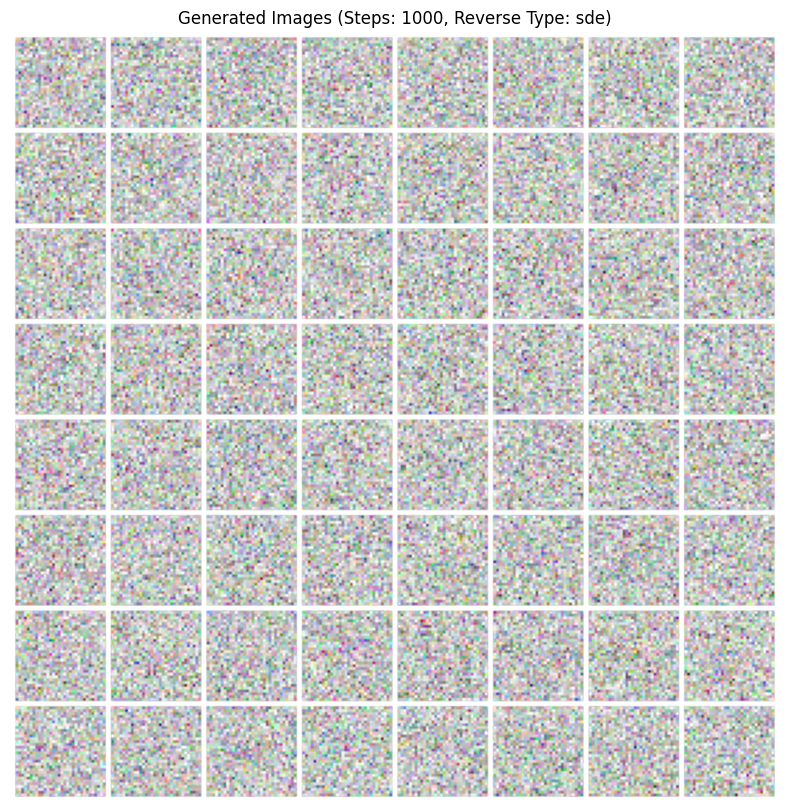

In [12]:

# --- 6. Visualize Results ---
show_images(generated_images,
            title = f"Generated Images (Steps: {reverse_cfg['N']}, Reverse Type: {reverse_cfg['rev_type']})",
            save_path = denoised_path)

# Decoding

In [13]:
from diffusers import AutoencoderKL
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(next(model.parameters()).device).eval()
VAE_SCALE_FACTOR = reverse_cfg['vae_scale_factor']



C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
torch.cuda.empty_cache()
torch.cuda.synchronize()

In [15]:
def decode_from_latent(latents: torch.Tensor):
    """Converte latenti in pixel [0, 1]."""
    latents = latents / VAE_SCALE_FACTOR
    with torch.no_grad():
        image = vae.decode(latents).sample
    return (image / 2 + 0.5).clamp(0, 1)

torch.Size([64, 3, 256, 256])


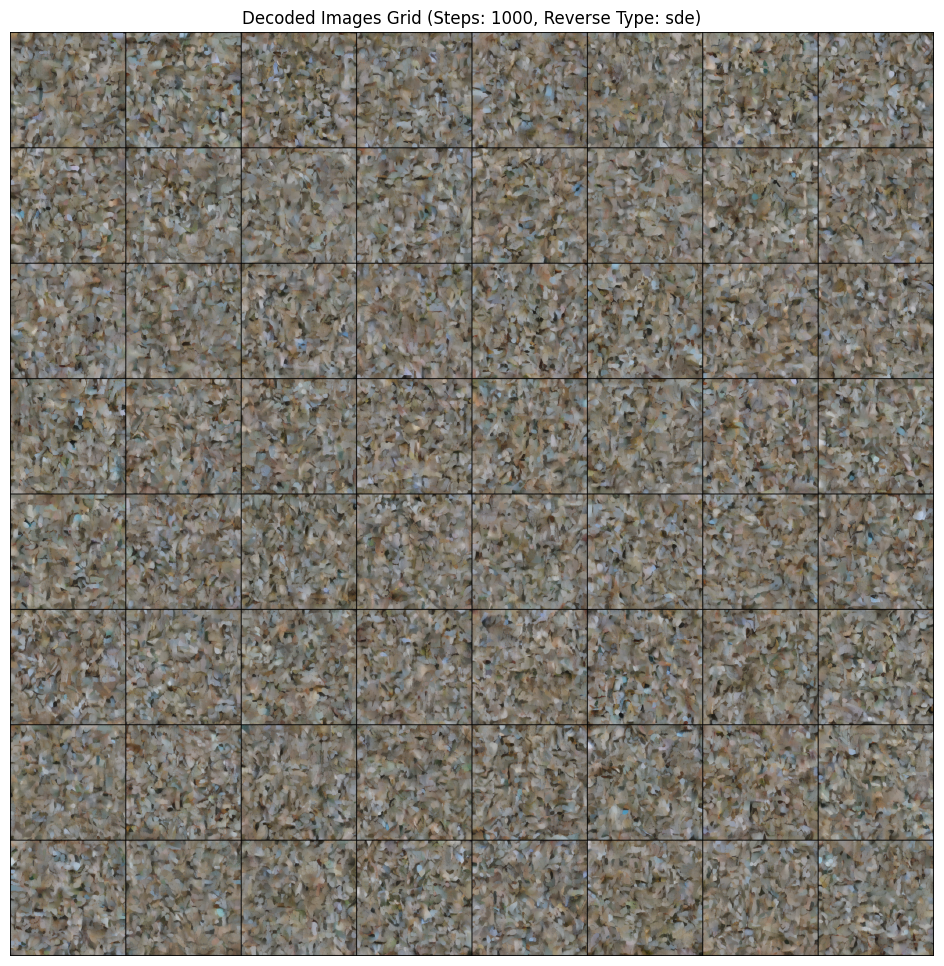

Decoded image grid saved to ..\images\decoded_1000_steps_sde__20251125_100612.png


In [29]:


decoded_images = []

# --- 1. Decodifica tutte le immagini e salva in una lista ---
for latent in generated_images:
    latent = latent.to(next(vae.parameters()).device, dtype=torch.float32).unsqueeze(0)
    decoded = decode_from_latent(latent)  # [1, C, H, W]
    decoded_images.append(decoded[0])      # Rimuovi dimensione batch

# --- 2. Crea un batch da lista di tensori ---
decoded_batch = torch.stack(decoded_images)  # [B, C, H, W]
print(decoded_batch.shape)
# --- 3. Crea griglia ---
grid = torchvision.utils.make_grid(decoded_batch, nrow=8, normalize=True, value_range=(0, 1))

# --- 4. Visualizza e salva ---
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0).cpu())  # [H, W, C]
plt.axis("off")
plt.title(f"Decoded Images Grid (Steps: {reverse_cfg['N']}, Reverse Type: {reverse_cfg['rev_type']})")

# Salva la griglia
decoded_grid_name = f"decoded_{details}_{timestamp}.png"
decoded_grid_path = os.path.join("..", "images", decoded_grid_name)
plt.savefig(decoded_grid_path, bbox_inches="tight")
plt.show()

print(f"Decoded image grid saved to {decoded_grid_path}")
